In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(PGSEA))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggradar))
suppressPackageStartupMessages(library(scales))
options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/')

functR <- 'priler_project/Software/model_clustering/clustering_functions.R'
Reactome_macro_file <- 'priler_project/refData/ReactomePathways_macro_2021.RData'
Reactome_macro_immune_file <- 'priler_project/refData/ReactomePathways_macro_Immune_2021.RData'
type_cluster <- 'Cases'
pval_feat <- 0.05
type_cluster_data <- 'tscore'
tissue_name <- 'DLPC_CMC'
pheno_name <- 'SCZ'
fold <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB/matchUKBB_clDLPC_CMC_'
fold_out <- 'priler_project/Figure_CASTom-iGEx_paper/SCZ_part2/matchUKBB_clDLPC_CMC_'
geneInfoFile <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/resPrior_regEval_allchr.txt'
genes_to_filter <- 'compare_prediction_UKBB_SCZ-PGC/DLPC_CMC_filter_genes_matched_datasets.txt'
tscore_featRel_tot_file <- sprintf('%stscoreOriginal_tscoreClusterCases_featAssociation.txt', fold)
tscore_featRel_info_file <- sprintf('%stscoreOriginal_tscoreClusterCases_infoGenes.txt', fold)
pathGO_featRel_tot_file <- sprintf('%spath_GOOriginal_tscoreClusterCases_featAssociation.txt', fold)
pathR_featRel_info_file <- sprintf('%spath_ReactomeOriginal_tscoreClusterCases_infopath.txt', fold)
pathGO_featRel_info_file <- sprintf('%spath_GOOriginal_tscoreClusterCases_infopath.txt', fold)
pathR_featRel_tot_file <- sprintf('%spath_ReactomeOriginal_tscoreClusterCases_featAssociation.txt', fold)
pathGO_featRel_summ_file <- sprintf('%stscore_zscaled_clusterCases_summary_path_GO_tissueSpec.txt', fold)
pathR_featRel_summ_file <- sprintf('%stscore_zscaled_clusterCases_summary_path_Reactome_tissueSpec.txt', fold)
tscore_summary_file <- sprintf('%stscore_zscaled_clusterCases_summary_geneLoci_allTissues.txt', fold)
pathR_noMHC_file <- sprintf('%spath_Reactome_notMHC_grSpec.txt', fold)
pathGO_noMHC_file <- sprintf('%spath_GO_notMHC_grSpec.txt', fold)

source(functR)

tscore_feat <- read.delim(tscore_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
tscore_info <- read.delim(tscore_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
tscore_feat_sign <- tscore_feat[tscore_feat$pval_corr <= 0.05, ]
tscore_summ <- read.delim(tscore_summary_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_feat <- read.delim(pathR_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_feat <- read.delim(pathGO_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_info <- read.delim(pathR_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_info <- read.delim(pathGO_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_summ <- read.delim(pathR_featRel_summ_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_summ <- read.delim(pathGO_featRel_summ_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_notMHC <- read.delim(pathR_noMHC_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_notMHC <- read.delim(pathGO_noMHC_file, h=T, stringsAsFactors = F, sep = '\t')

tscore_feat_tissue <- tscore_feat[tscore_feat$tissue %in% tissue_name, ]



Warning message:
“Package 'KEGG.db' is deprecated and will be removed from Bioconductor
  version 3.12”


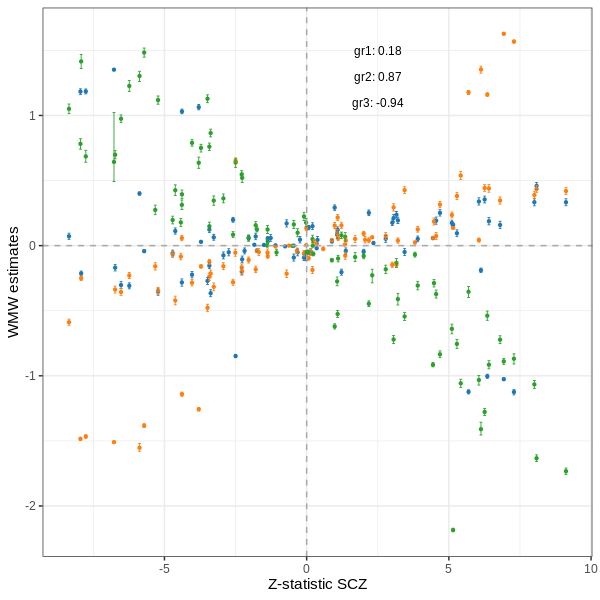

In [2]:
######################################################################
### plot Z-stat versus WMW estimates in tissue used for clustering ###
######################################################################

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
# remove duplicates
tmp <- tscore_info[tscore_info$tissue %in% tissue_name, ]
id_dup <- tmp$external_gene_name[duplicated(tmp$external_gene_name)]
if(length(id_dup)>0){
  tmp <- tmp[!tmp$external_gene_name %in% id_dup, ]
}
tscore_feat_tissue$Zstat <- tmp$Zstat[match(tscore_feat_tissue$feat, tmp$external_gene_name)]
tscore_feat_tissue$gr <- unname(sapply(tscore_feat_tissue$comp, function(x) strsplit(x, split = '_vs_all')[[1]]))
tscore_feat_tissue$gr <- factor(tscore_feat_tissue$gr)

# only significant
feat_red <- tscore_feat_tissue[tscore_feat_tissue$pval_corr<= pval_feat, ]
df_corr <- feat_red %>% 
  group_by(gr) %>% 
  summarise(sp_corr = cor(Zstat, estimates, method = 'spearman'), 
            sp_corr_pval = cor.test(Zstat, estimates, method = 'spearman')$p.value)
df_corr <- as.data.frame(df_corr)
df_corr$label <- paste(df_corr$gr,round(df_corr$sp_corr, digits = 2), sep = ': ')
df_corr$x <- 2.5
df_corr$y <- c(1.5, 1.3,1.1)

pl1 <-  ggplot(feat_red, aes(x = Zstat, y = estimates, color = gr, ymin = CI_low, ymax =CI_up))+
  geom_point(size = 0.8)+geom_errorbar(width = 0.1, size = 0.3)+
  ylab('WMW estimates')+xlab('Z-statistic SCZ')+
  geom_vline(xintercept = 0, linetype = 'dashed', color = 'darkgrey')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'darkgrey')+
  # geom_smooth(method = 'lm', formula = y~x, se = T, size = 0.4)+
  # scale_color_d3()+
  #geom_text(aes(x=x, y=y, label=label, color = gr))+
  annotate("text", x = df_corr$x, y = df_corr$y, label = df_corr$label, size=3)+
  scale_color_d3()+
  theme_bw()+theme(legend.position = 'none', legend.title = element_blank())
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compare_Zstat_est.png',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'png')
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compare_Zstat_est.pdf',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'pdf')

# print:
pl1
                                       


[1] "significant genes in MHC across all tissues: 557 out of 687"
[1] "percentage genes in MHC across all tissues: 0.810771470160116"


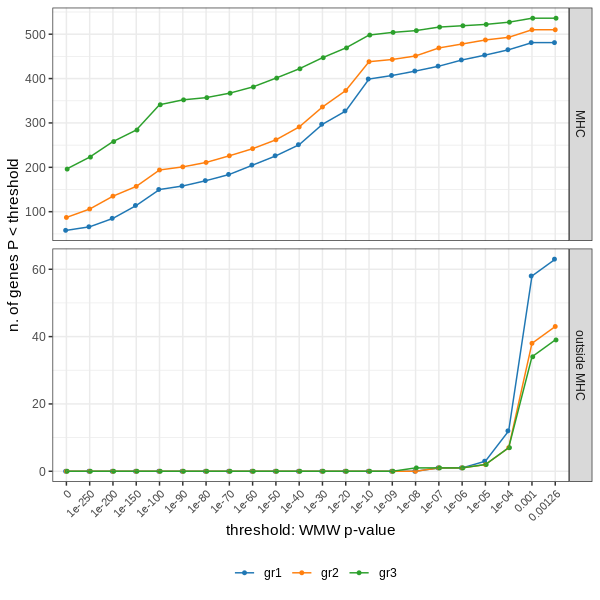

In [3]:
################################################################
### plot distribution p-values clust specific: MHC vs no MHC ###
################################################################
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)

genes_MHC <- strsplit(tscore_summ$gene[tscore_summ$loci_id == 'chr6:23.9-34.9Mb'], split = ',')[[1]]
# percentage of group-specifc genes located in MHC:
print(paste('significant genes in MHC across all tissues:', tscore_summ$ngenes_withrep[tscore_summ$loci_id == 'chr6:23.9-34.9Mb'], 'out of', sum(tscore_summ$ngenes_withrep)))
# "significant genes in MHC across all tissues: 557 out of 687"
print(paste('percentage genes in MHC across all tissues:', tscore_summ$ngenes_withrep[tscore_summ$loci_id == 'chr6:23.9-34.9Mb']/sum(tscore_summ$ngenes_withrep)))
# "percentage genes in MHC across all tissues: 0.81"
tscore_feat_sign$class <- 'outside MHC'
tscore_feat_sign$class[tscore_feat_sign$feat %in% genes_MHC] <- 'MHC'
tscore_feat_sign$class <- factor(tscore_feat_sign$class, levels = c('MHC', 'outside MHC'))
tscore_feat_sign$gr <- unname(sapply(tscore_feat_sign$comp, function(x) strsplit(x, split = '_vs_all')[[1]]))
tscore_feat_sign$gr <- factor(tscore_feat_sign$gr)
tscore_feat_sign$tr_pval <- -log10(tscore_feat_sign$pval)


# cumulative counts
pval_thr <- rev(c(seq(10, 100, by=10), seq(150, 250, by=50)))
pval_thr <- c(0, 1/10^(pval_thr), 1/10^(9:3), max(tscore_feat_sign$pval))

df_count <- list()
for(i in 1:length(pval_thr)){
  df_count[[i]] <- tscore_feat_sign %>% 
    group_by(class,gr) %>% 
    summarise(count = sum(pval<=pval_thr[i]), .groups = 'drop') %>%
    add_column(thr = pval_thr[i])
}
df_count <- bind_rows(df_count)
df_count <- as.data.frame(df_count)
df_count$thr <- factor(df_count$thr, levels = pval_thr)

pl1 <-  ggplot(df_count, aes(x = thr, y = count, color = gr, group = gr))+
  geom_point(position = position_dodge(width = 0.1), size=1)+
  geom_line()+
  facet_wrap(class~., scales = 'free_y',ncol =  1, strip.position="right")+
  ylab('n. of genes P < threshold')+
  xlab('threshold: WMW p-value')+
  # scale_fill_d3()+
  scale_color_d3()+
  theme_bw()+theme(legend.position = 'bottom', legend.title = element_blank(), 
                   axis.text.x = element_text(angle = 45, hjust = 1, size = 8))
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compareDist_MHC_noMHC.png',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'png')
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compareDist_MHC_noMHC.pdf',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'pdf')

# print
pl1

In [8]:
#################################################
### cliclize plot: MHC versus not MHC (count) ###
#################################################

class_genes <- c('MHC', 'outside MHC')
tscore_feat_sign$feat_tissue <- paste0(tscore_feat_sign$feat,'_',tscore_feat_sign$tissue)
df_class <- data.frame(class = class_genes, count = sapply(class_genes, function(x) length(unique(tscore_feat_sign$feat_tissue[tscore_feat_sign$class == x]))))
df_class$fraction <- df_class$count / sum(df_class$count)
df_class$ymax <- cumsum(df_class$fraction)
df_class$ymin <- c(0, head(df_class$ymax, n=-1))
df_class$labelPosition <- (df_class$ymax + df_class$ymin) / 2
# Compute a good label
df_class$label <- paste0(df_class$class, '\n', df_class$count, ' genes')
df_class
                                                           
tscore_feat_sign_new <- tscore_feat_sign
tscore_feat_sign$comp <- unname(sapply(tscore_feat_sign_new$comp, function(x) strsplit(x, split = '_vs_all')[[1]][1]))
tscore_feat_sign_new <- tscore_feat_sign_new[!duplicated(tscore_feat_sign_new$feat_tissue), ]
tscore_feat_sign_new$comp_multiple <- NA
for(i in 1:nrow(tscore_feat_sign_new)){

    tmp <- tscore_feat_sign$comp[tscore_feat_sign$feat_tissue == tscore_feat_sign_new$feat_tissue[i]]
    tscore_feat_sign_new$comp_multiple[i] <- paste0(tmp, collapse = ',')
}
df_class_gr <- tscore_feat_sign_new %>% 
    group_by(class,comp_multiple) %>% 
    summarise(count = n(), .groups = 'drop') 
df_class_gr <- as.data.frame(df_class_gr)
df_class_gr$fraction <- df_class_gr$count / sum(df_class_gr$count)
df_class_gr                                       
df_class_gr_plot <- data.frame(gr = rep(sort(unique(tscore_feat_sign$comp)), 2), 
                               class = unlist(lapply(class_genes, function(x) rep(x, length(unique(tscore_feat_sign$comp))))))

# specifically for 3 groups
# gr1
max1 <- sum(df_class_gr$fraction[grepl('gr1',df_class_gr$comp_multiple) & df_class_gr$class == 'MHC'])
max2 <- sum(df_class_gr$fraction[grepl('gr1',df_class_gr$comp_multiple) & df_class_gr$class == 'outside MHC'])
df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr1'] <- df_class$ymin
df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr1'] <- c(max1, df_class$ymin[df_class$class == 'outside MHC'] + max2)          

# gr2
df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2'] <- df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr1'] - 
                         sapply(class_genes, function(x) sum(df_class_gr$fraction[grepl('gr1,gr2',df_class_gr$comp_multiple) & df_class_gr$class == x]))                
max1 <- sum(df_class_gr$fraction[grepl('gr2',df_class_gr$comp_multiple) & df_class_gr$class == 'MHC'])
max2 <- sum(df_class_gr$fraction[grepl('gr2',df_class_gr$comp_multiple) & df_class_gr$class == 'outside MHC'])
df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr2'] <- c(max1, max2) + df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2']

# gr3
for(i in class_genes){
    tmp <- df_class_gr[grepl('gr3',df_class_gr$comp_multiple) & df_class_gr$class == i,]
    if('gr1,gr2,gr3' %in% tmp$comp_multiple & 'gr1,gr3' %in% tmp$comp_multiple){
        # start
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2' & df_class_gr_plot$class == i] - sum(df_class_gr$fraction[grepl('gr1,gr3',df_class_gr$comp_multiple) & df_class_gr$class == i])
        df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
        # end
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2' & df_class_gr_plot$class == i] + sum(df_class_gr$fraction[grepl('gr1,gr2,gr3',df_class_gr$comp_multiple) & df_class_gr$class == i])
        df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
    }
    if((!'gr1,gr2,gr3' %in% tmp$comp_multiple) & 'gr1,gr3' %in% tmp$comp_multiple){
        # start
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr1' & df_class_gr_plot$class == i]
        df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
        # end
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr1' & df_class_gr_plot$class == i] + sum(df_class_gr$fraction[grepl('gr1,gr3',df_class_gr$comp_multiple) & df_class_gr$class == i])
        df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
    }
    if('gr2,gr3' %in% tmp$comp_multiple){
        new_row <- data.frame(gr = 'gr3', class = i)
        # start
        new_value <- df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr2' & df_class_gr_plot$class == i] - df_class_gr$fraction[df_class_gr$comp_multiple == 'gr2,gr3' & df_class_gr$class == i]
        new_row$ymin <- new_value
        # end
        new_value <- df_class$ymax[df_class$class == i] 
        new_row$ymax <- new_value
        df_class_gr_plot <- rbind(df_class_gr_plot, new_row)
   }
        
}
df_class_gr_plot

# save
write.table(file = sprintf('%stscoreOriginal_%sCluster%s_perc_MHC_noMHC.txt',fold_out,type_cluster_data,type_cluster), 
           x = df_class_gr, col.names = T,row.names = F, sep = '\t', quote = F)

,class,count,fraction,ymax,ymin,labelPosition,label
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MHC,MHC,557,0.8107715,0.8107715,0.0000000,0.4053857,MHC 557 genes
outside MHC,outside MHC,130,0.1892285,1.0000000,0.8107715,0.9053857,outside MHC 130 genes


class,comp_multiple,count,fraction
<fct>,<chr>,<int>,<dbl>
MHC,gr1,1,0.001455604
MHC,"gr1,gr2",17,0.024745269
MHC,"gr1,gr2,gr3",430,0.625909753
MHC,"gr1,gr3",33,0.048034934
MHC,gr2,3,0.004366812
MHC,"gr2,gr3",60,0.087336245
MHC,gr3,13,0.018922853
outside MHC,gr1,49,0.071324600
outside MHC,"gr1,gr2",9,0.013100437


gr,class,ymin,ymax
<chr>,<chr>,<dbl>,<dbl>
gr1,MHC,0.000000000,0.7001456
gr2,MHC,0.049490539,0.7918486
gr3,MHC,0.001455604,0.6754003
gr1,outside MHC,0.810771470,0.9024745
gr2,outside MHC,0.889374090,0.9519651
gr3,outside MHC,0.810771470,0.8180495
gr3,MHC,0.704512373,0.8107715
gr3,outside MHC,0.950509461,1.0000000


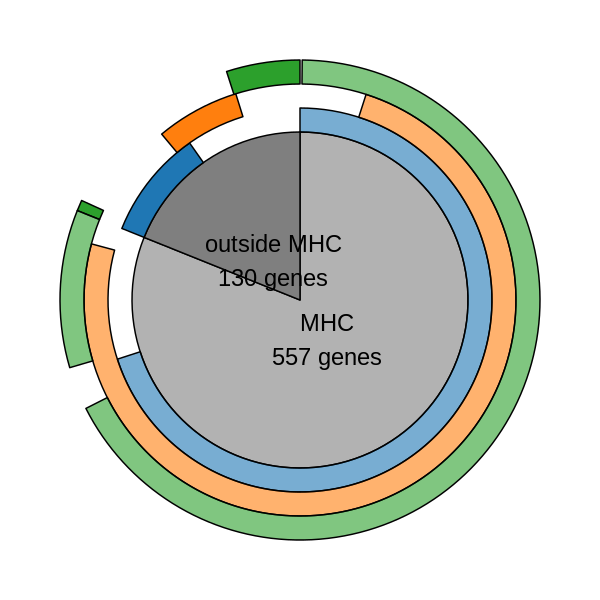

In [5]:
colors_gr <- pal_d3(palette = 'category20')(3)

pl <- ggplot(df_class, aes(ymax=ymax, ymin=ymin, xmax=6, xmin=-1, alpha=class)) +
  geom_rect(color = 'black', fill = 'grey50') +
  geom_rect(data = subset(df_class_gr_plot, gr == 'gr1'), mapping = aes(ymax=ymax, ymin=ymin, xmax=7, xmin=6, alpha=class), 
              fill = colors_gr[1], color = 'black',
              inherit.aes = FALSE) +
  geom_rect(data = subset(df_class_gr_plot, gr == 'gr2'), mapping = aes(ymax=ymax, ymin=ymin, xmax=8, xmin=7, alpha=class), 
              fill = colors_gr[2], color = 'black',
              inherit.aes = FALSE) +
  geom_rect(data = subset(df_class_gr_plot, gr == 'gr3'), mapping = aes(ymax=ymax, ymin=ymin, xmax=9, xmin=8, alpha=class), 
              fill = colors_gr[3], color = 'black',
              inherit.aes = FALSE) +
  geom_text(x = 1, aes(y=labelPosition, label=label), color = 'black', size=6, alpha = 1) + # x here controls label position (inner / outer)
  scale_alpha_manual(values = c(0.6, 1)) +
  coord_polar(theta="y") +
  xlim(c(-1, 9)) +
  theme_void() +
  theme(legend.position = "none")
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_overlapSignGenes.png',fold_out,type_cluster_data,type_cluster), width = 5, height = 5, plot = pl, device = 'png')
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_overlapSignGenes.pdf',fold_out,type_cluster_data,type_cluster), width = 5, height = 5, plot = pl, device = 'pdf')

# print 
pl


In [ ]:
#################################
### n. genes and n. loci plot ###
#################################



